In [19]:
import os
import torch
from toolkit import *
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision import models

from torchvision import transforms 
from torchvision.transforms import Compose 
import torch.optim as optim

%config InlineBackend.figure_format = 'retina'

# Ye Tao

In [3]:
devkit_path = Path('./car_devkit/devkit')
train_path = Path('./cars_train/cars_train')
test_path = Path('./cars_test/cars_test')

cars_meta = loadmat(devkit_path/'cars_meta.mat')
cars_train_annos = loadmat(devkit_path/'cars_train_annos.mat')
cars_test_annos = loadmat(devkit_path/'cars_test_annos.mat')

In [4]:
def load_data(cars_annots, labels, path, train = None):

    tmp = [[i.flat[0] for i in line] for line in cars_annots['annotations'][0]]

    if train == True:
        columns = ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'class', 'fname']
        labels = pd.DataFrame(labels, columns=['labels'])

    if train == False: 
        columns = ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'fname']

    df = pd.DataFrame(tmp, columns=columns)
    df['fname'] = [path/f for f in df['fname']]
    
    if train == True:
        df['class'] = df['class']-1 # Python indexing starts on zero.
        df = df.merge(labels, left_on='class', right_index=True).sort_index()

    return df

In [5]:
labels, dist = np.unique([c for c in cars_meta['class_names'][0]], return_counts = True)
df_train = load_data(cars_annots=cars_train_annos, labels = labels, train=True, path = train_path)
df_train = df_train.sample(frac = 0.1).reset_index(drop = True)
df_train.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,fname,labels
0,19,60,783,440,111,cars_train/cars_train/00094.jpg,Ford Fiesta Sedan 2012
1,209,290,875,590,129,cars_train/cars_train/04198.jpg,Hyundai Accent Sedan 2012
2,20,74,562,370,120,cars_train/cars_train/03134.jpg,GMC Terrain SUV 2012
3,39,183,1007,686,127,cars_train/cars_train/06109.jpg,Honda Odyssey Minivan 2007
4,7,56,286,174,107,cars_train/cars_train/06964.jpg,Ford Expedition EL SUV 2009


In [6]:
df_train.shape

(814, 7)

In [7]:
df_test = load_data(cars_annots=cars_test_annos, labels = labels, train=False, path = test_path)
df_test.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,fname
0,30,52,246,147,cars_test/cars_test/00001.jpg
1,100,19,576,203,cars_test/cars_test/00002.jpg
2,51,105,968,659,cars_test/cars_test/00003.jpg
3,67,84,581,407,cars_test/cars_test/00004.jpg
4,140,151,593,339,cars_test/cars_test/00005.jpg


In [8]:
def display_picture(df, nrows, ncols):
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 10))  # make one subplot (ax) on the figure
    axes = axes.flatten() # it comes out as a 2D matrix; convert to a vector
    for idx in range(len(axes)):
    
        xy = df['bbox_x1'][idx], df['bbox_y1'][idx]
        w, h = df['bbox_x2'][idx] - df['bbox_x1'][idx], df['bbox_y2'][idx] - df['bbox_y1'][idx]
        rect = Rectangle(xy, w, h, fill=False, color='black', linewidth=2)

        label = df['labels'][idx]
        image = Image.open(df["fname"][idx])
        rect = Rectangle(xy, w, h, fill=False, color='r', linewidth=2)

        axes[idx].add_patch(rect)
        axes[idx].imshow(image)
        axes[idx].set_title(label, size = 8)
        
    plt.tight_layout() # I add this anytime I have a grid as it "does the right thing"
    plt.show()

In [9]:
train, val = train_test_split(df_train, test_size = 0.2)
train, val = train.reset_index(drop=True), val.reset_index(drop=True)

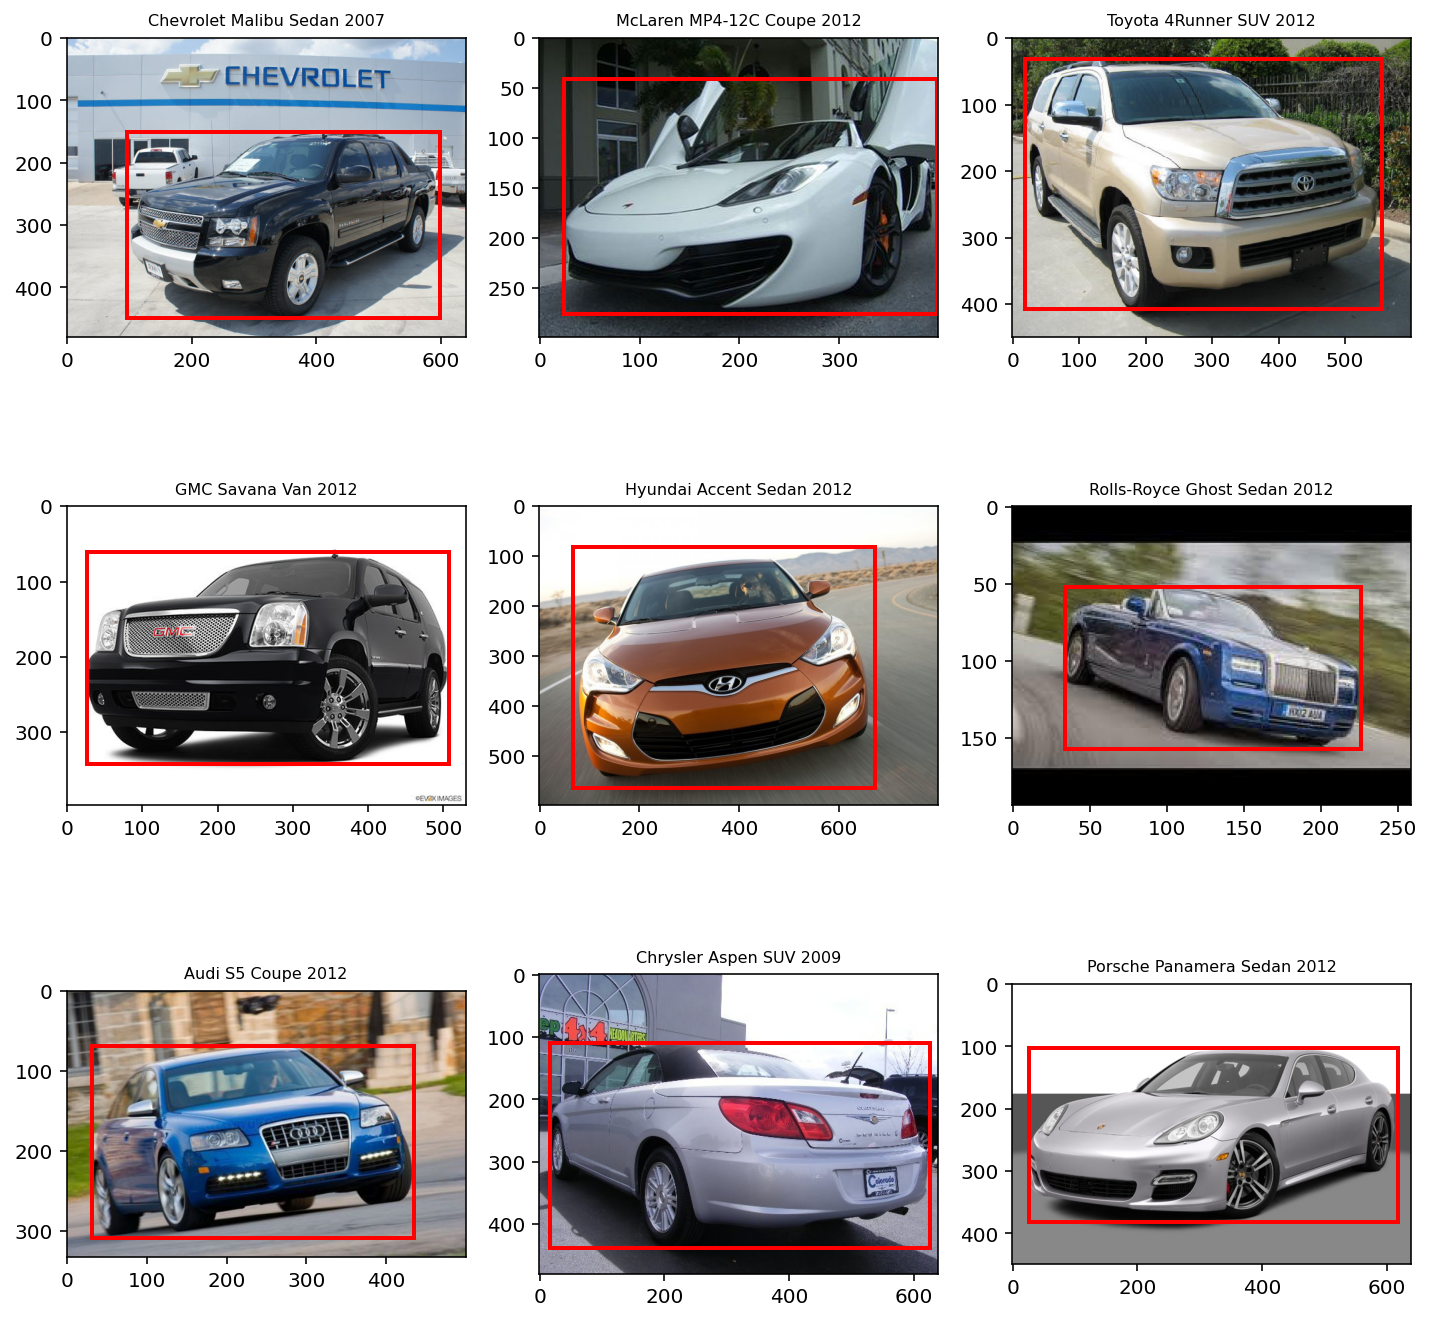

In [10]:
# train
display_picture(train, nrows=3, ncols=3)

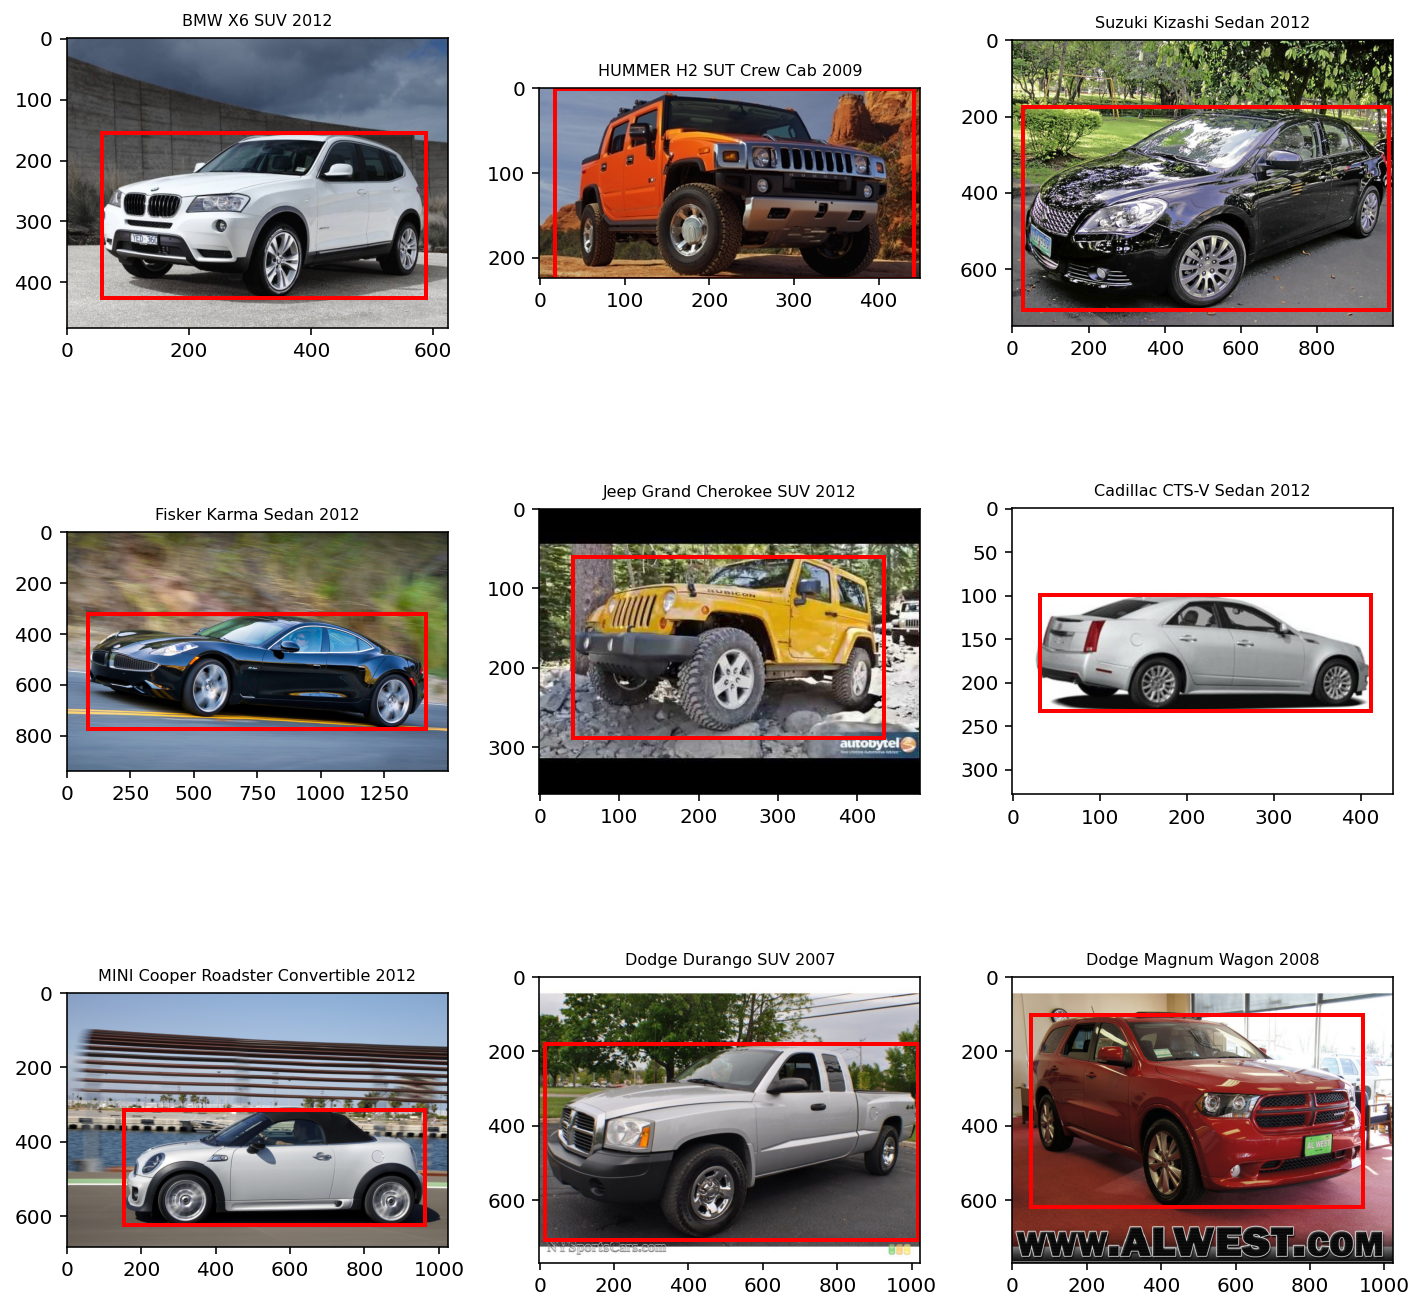

In [11]:
# val
display_picture(val, nrows=3, ncols=3)


1. Create a model that only classifies the cars. Make a note of the accuracy of this model.

In [109]:
# Dataset with resizing option
class CarDataset(Dataset):
    def __init__(self, df, resize=False, transform = None):
        self.df = df
        self.data_path = df['fname']
        self.resize = resize
        self.transform = transform
        
        # label dictionary
        self.label_dict = {label: idx for idx, label in enumerate(np.unique(df["labels"]))}
        
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        
        row = self.df.iloc[idx]
        path = row['fname']
        
        # read the img
        img = cv2.imread(str(path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            img = self.transform(img)
            
        # resize image
        if self.resize == True:
            img = cv2.resize(np.array(img), (500, 400))
        
        # move color channels to correct spot
        img = np.transpose(img, (2, 0, 1))
        
        # convert to [0,1] scale
        img = torch.tensor(img / 255.).float()
        label = torch.tensor(self.label_dict[row['labels']])
        
        return img, label.squeeze()

In [46]:
# dta augment
train_transform = Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4)
])

test_transform = Compose([
    transforms.ToPILImage(),
])

ds_train, ds_val = CarDataset(train, resize = True, transform = train_transform), CarDataset(val, resize = True)
dl_train = DataLoader(ds_train, batch_size=8, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=20, shuffle=False)

x, y = next(iter(dl_train))
x.shape, y.shape

print(x, y)

triggered
triggered
triggered
triggered
triggered
triggered
triggered
triggered
tensor([[[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.9922, 0.9922, 0.9922,  ..., 0.9922, 0.9922, 0.9922],
          [0.9922, 0.9922, 0.9922,  ..., 0.9922, 0.9922, 0.9922],
          [0.9922, 0.9922, 0.9922,  ..., 0.9922, 0.9922, 0.9922]],

         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.9922, 0.9922, 0.9922,  ..., 0.9922, 0.9922, 0.9922],
          [0.9922, 0.9922, 0.9922,  ..., 0.9922, 0.9922, 0.9922],
          [0.9922, 0.9922, 0.9922,  ..., 0.9922, 0.9922, 0.9922]],

         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1

In [14]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1)
        
        self.linear1 = nn.Linear(3100, 400)
        # we totally have 196 unique classes
        self.linear2 = nn.Linear(400, 196)
        
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        self.relu = nn.ReLU()
        
        self.unroll = nn.Flatten()
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        
        x = self.relu(self.conv3(x))
        x = self.pool(x)

        x = self.unroll(x) # don't forget to unroll it
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [15]:
def one_pass(model, dataloader, optimizer, lossFun, backwards=True, print_loss=False):
    
    if backwards == True:
        model.train()
    else:
        model.eval()
    
    total_loss = 0.0
    for x, y in dataloader:
        
        y_pred = model(x)
        loss = lossFun(y_pred, y)
        total_loss += loss.item()
        
        if backwards == True:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    avg_loss = total_loss / len(dataloader)
    
    if print_loss == True:
        print(avg_loss)
    
    return avg_loss

def one_pass_acc(model, dataloader, num_points):
    model.eval()
    total_incorrect = 0
    
    softmax = nn.LogSoftmax(dim=1)
    
    for x, y in dataloader:
        y_pred = softmax(model(x))
        y_pred = torch.argmax(y_pred, dim=1)
        
        total_incorrect += torch.count_nonzero(y - y_pred).item()
        
    percent_wrong = total_incorrect / num_points
    return 1 - percent_wrong

In [16]:
model = Net()
lossFun = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.1)

In [17]:
y_pred = model(x)
loss = lossFun(y_pred, y)
loss

tensor(5.2904, grad_fn=<NllLossBackward>)

In [18]:
model = Net()
lossFun = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.1)


num_epochs = 2
train_losses = []
valid_losses = []

for epoch in tqdm(range(num_epochs)):
    print('Epoch: ', epoch)
    
    train_loss = one_pass(model, dl_train, optimizer, lossFun)
    train_losses.append(train_loss)
    print('Train loss: ', train_loss)
    
    valid_loss = one_pass(model, dl_val, optimizer, lossFun, backwards=False)
    valid_losses.append(valid_loss)
    print('Valid loss: ', valid_loss)
    
    train_acc = one_pass_acc(model, dl_train, len(ds_train))
    valid_acc = one_pass_acc(model, dl_val, len(ds_val))
    print('Train Acc: ', train_acc)
    print('Valid Acc: ', valid_acc)
    
print('Finished Training')

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch:  0
Train loss:  5.628281477021008
Valid loss:  5.451756689283583
Train Acc:  0.010752688172043001
Valid Acc:  0.006134969325153339
Epoch:  1
Train loss:  5.2926926671004875
Valid loss:  5.397421836853027
Train Acc:  0.01228878648233489
Valid Acc:  0.006134969325153339
Finished Training


- https://towardsdatascience.com/bounding-box-prediction-from-scratch-using-pytorch-a8525da51ddc
- https://medium.com/swlh/how-data-augmentation-improves-your-cnn-performance-an-experiment-in-pytorch-and-torchvision-e5fb36d038fb
- https://towardsdatascience.com/getting-started-with-albumentation-winning-deep-learning-image-augmentation-technique-in-pytorch-47aaba0ee3f8
- https://www.kaggle.com/simpletonwang/dl-hw2


2. Use a similar model architecture to both classify the cars and predict the bounding box by summing the loss functions for each task: CrossEntropyLoss and L1Loss. Compute the accuracy for the classification task and the IoU score for the bounding box prediction task. How does the accuracy of this model compare to the just classification model from before?

In [ ]:
class RoadDataset(Dataset):
    def __init__(self, paths, bb, y, transforms=False):
        self.transforms = transforms
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        x, y_bb = transformsXY(path, self.bb[idx], self.transforms)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb

In [115]:
class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        
        # same padding!
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1)
        
        self.linear1 = nn.Linear(2000, 500) #40*50
    
        self.linear2 = nn.Linear(500, 196) # 196-class classification
        self.linear2_1 = nn.Linear(500, 4) 
        
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.pool2 = nn.MaxPool2d(kernel_size=5)
    
        self.relu = nn.ReLU()
        self.unroll = nn.Flatten()
        
    def forward(self, x):
        # helpful to do this along the way sometimes!
        #print(x.shape)
        
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)
        

        x = self.conv3(x)
        x = self.relu(x)
        
        x = self.linear1(self.unroll(x))
        x = self.relu(x)
        
        return self.linear2(x), self.linear2_1(x) #label, bbox

In [114]:
def one_pass(model, dataloader, optimizer, lossFun, backwards=True, print_loss=False, c=1):
    
    if backwards == True:
        model.train()
    else:
        model.eval()
    
    total_loss = 0.0
    for x, y, y_bb in dataloader:
        
        y_bb = y_bb.float()
        y_pred, out_bb = model(x)
        loss_class = lossFun(y_pred, y, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        tmp_loss = loss_class + loss_bb/C
        total_loss += tmp_loss
        
        if backwards == True:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
    avg_loss = total_loss / len(dataloader)
    
    if print_loss == True:
        print(avg_loss)
    
    return avg_loss


def one_pass_acc(model, dataloader, num_points):
    model.eval()
    total_incorrect = 0
    
    softmax = nn.LogSoftmax(dim=1)
    
    for x, y in dataloader:
        y_pred = softmax(model(x))
        y_pred = torch.argmax(y_pred, dim=1)
        
        total_incorrect += torch.count_nonzero(y - y_pred).item()
        
    percent_wrong = total_incorrect / num_points
    return 1 - percent_wrong


def one_pass_iou(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # Or thresholded.mean() if you are interested in average across the batch

In [ ]:
# dta augment
train_transform = Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4)
])

test_transform = Compose([
    transforms.ToPILImage(),
])

ds_train, ds_val = CarDataset(train, resize = True, transform = train_transform), CarDataset(val, resize = True)
dl_train = DataLoader(ds_train, batch_size=8, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=20, shuffle=False)

x, y = next(iter(dl_train))
x.shape, y.shape

print(x, y)

In [ ]:
model = Net2()
lossFun = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.1)

In [ ]:
num_epochs = 2
train_losses = []
valid_losses = []

for epoch in tqdm(range(num_epochs)):
    print('Epoch: ', epoch)
    
    train_loss = one_pass(model, dl_train, optimizer, lossFun)
    train_losses.append(train_loss)
    print('Train loss: ', train_loss)
    
    valid_loss = one_pass(model, dl_val, optimizer, lossFun, backwards=False)
    valid_losses.append(valid_loss)
    print('Valid loss: ', valid_loss)
    
    train_acc = one_pass_acc(model, dl_train, len(ds_train))
    valid_acc = one_pass_acc(model, dl_val, len(ds_val))
    print('Train Acc: ', train_acc)
    print('Valid Acc: ', valid_acc)
    
    train_iou = one_pass_iou(model, dl_train, len(ds_train))
    valid_iou = one_pass_iou(model, dl_val, len(ds_val))
    
print('Finished Training')

3. Try training this model with different weights on the two loss functions. For instance you might try: CrossEntropyLoss + 20 × L1Loss. Observe how the performance of the model changes at the two tasks as you adjust the weight. Is there a sweet spot?

In [ ]:
num_epochs = 2
train_losses = []
valid_losses = []

for epoch in tqdm(range(num_epochs)):
    print('Epoch: ', epoch)
    
    train_loss = one_pass(model, dl_train, optimizer, lossFun, c = 20)
    train_losses.append(train_loss)
    print('Train loss: ', train_loss)
    
    valid_loss = one_pass(model, dl_val, optimizer, lossFun, backwards=False)
    valid_losses.append(valid_loss)
    print('Valid loss: ', valid_loss)
    
    train_acc = one_pass_acc(model, dl_train, len(ds_train))
    valid_acc = one_pass_acc(model, dl_val, len(ds_val))
    print('Train Acc: ', train_acc)
    print('Valid Acc: ', valid_acc)
    
    train_iou = one_pass_iou(model, dl_train, len(ds_train))
    valid_iou = one_pass_iou(model, dl_val, len(ds_val))
    
print('Finished Training')